# The NBA in the 2010s
## Matthew Zimolzak, Li Zhou
### University of Michigan

**Author Note:** This project was developed in fulfillment of an educational requirement as specified by the SIADS 591/592 milestone course offered through the Master of Applied Data Science program by the School of Information at the University of Michigan.  The authors Matthew Zimolzak and Li Zhou may be contacted with inquiries via email at zimolzak@umich.edu and lizhoula@umich.edu respectively.

## Motivation
For years, the use of analytics in sports has been an effective way to diagnose what is happening on the field of play.  This has become increasingly true with recent developments in data collection and management technologies that facilitate the application of diverse numerical approaches to sports data.  In this project, we will explore NBA data specific to the 2010s starting with the 2010-2011 season and ending with the 2019-2020 season.  As the sport of basketball continues to evolve, so do the data and trends within.  We aim to address specific questions that include the following:
* Are there any trends that indicate a change in playing style?  
* Who are the stars of the NBA past, present, and future?
* Which players are the most overvalued/undervalued?
* How has the league-wide distribution of star players changed over the last decade?

## Data Sources
The first data set was compiled from Basketball Reference which offers one of the most complete and in-depth catalogues of basketball statistics on the web.  Utilizing HTML web scraping techniques to create a CSV file, we gathered regular season per-game box score statistics for every player from each league year starting with the 2010-2011 season and ending with the 2019-2020 season for a total of 6,208 records.  Variables of interest include, but are not limited to, points, assists, rebounds, steals, blocks, turnovers, and shooting percentage.  Additionally, we included a new field to denote which year (‘Year’) is associated with each record.  For example, the 2010-2011 season is labeled simply as 2011. <br /> (https://www.basketball-reference.com/leagues/NBA_2020_per_game.html)<br /><br />
The remaining datasets were gathered from sportsdata.io, an API that returns JSON formatted data.  We selected unique data outside the realm of standard basketball statistics such as height, weight, salary, and years of experience for active players as well as team data consisting of city, division, conference, and colors for a total of 576 and 30 records respectively. 
<br />(Player data: https://api.sportsdata.io/v3/nba/scores/json/Players?key=a3824595f2f740dbb21dd847e49ba332 <br />
Team data: https://api.sportsdata.io/v3/nba/scores/json/Teams?key=a3824595f2f740dbb21dd847e49ba332)


## Data Manipulation Methods
Our box score dataset first required some basic cleaning.  Cleaning steps include removing intermediate headers, relabeling hyphenated player positions to just a single position (e.g., SF-SG became SG), removing non-alphanumeric characters (asterisks which denote Hall of Fame status), replacing non-English characters with their English equivalent (to allow for the joining of the datasets), and consolidating organizations that underwent name changes into a single name.  Additionally, some players had multiple records per season which indicates playing for multiple teams in a season.  In league wide analysis, we removed the records with the team name ‘TOT’, the aggregate record for the player during that season, instead electing to use the team splits so as to avoid double counting.  Then, when doing individual player analysis, we kept the records with the team name ‘TOT’ in order to accurately reflect that individual’s performance.  Other manipulations unique to this dataset (outside of cleaning) involve converting string values to numeric values,  aggregating relevant statistics by both season and position in terms of both absolute values and proportions, and sorting/ordering/aggregating by a variety of fields.  Finally, we made use of some advanced metrics, the explanations and formulas for which are given below:
#### Approximate Value (AV)
Approximate value is the metric which is an estimate of a player’s value, making no fine distinctions, but, rather, distinguishing easily between very good seasons, average seasons, and poor seasons. (Approximate Value (AV) Explained)<br /><br />
Credits = (Points) + (Rebounds) + (Assists) + (Steals) + (Blocks)
	  - (Field Goals Missed) - (Free Throws Missed) - (Turnovers)

Approximate Value (AV) = (Credits<sup>(3/4)</sup>) / 21

#### Trade Value (TV)
Trade value is the estimate using a player’s age and his approximate value to determine how much value a player has left in his career.  Invented by Bill James. (Trade Value Explained)

Trade Value (TV) = [(AV - 27 -0.75Age)<sup>2</sup>(27 -0.75Age + 1)AV]/190 + 2AV/13

The datasets from the sportsdata.io API did not require nearly as much cleaning or manipulation.  Aside from reconciling team names as was necessary with the first dataset, we only needed to add a pound sign (#) to the color fields so that they could be used in creating our visualizations.  These two datasets alone did not prove useful in our analysis and only after joining with the per-game statistics was their value realized.<br /><br />When necessary, we joined (pd.merge) the per-game statistics dataset with either the API player data using player name as the key or the API team data using team name as the key.  The purpose of the former was to connect salary and experience with each player while the purpose of the latter was to connect team name with team colors to allow for coloring based on team.  In order to allow for the comparison between Approximate Value and salary, we performed a z-transformation so that the values for each would be on a comparable scale.  These values were then filtered by experience for one specific situation as we discuss below.  Additionally we fit a linear regression line involving salary and Approximate Value which was then plotted on top of a scatter plot.

## Preliminary

In [1]:
#Import useful libraries
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings #optional
warnings.simplefilter(action='ignore', category=FutureWarning) #supressed future warning (optional)
pd.set_option('mode.chained_assignment', None) #supresses chained assignment warning (optional)

In [2]:
#Read in necessary files

regular_2010s = pd.read_csv('../regular_season_2010s.csv')
players = pd.read_csv('../player_data.csv')
teams = pd.read_csv('../team_data.csv')

In [3]:
#We will replace the team name to standard ones that will coincide with names in the regular_2010s dataframe

teams.loc[:,('Tm')] = teams.loc[:,('Tm')].str.replace(r'^NO$','NOP')
teams.loc[:,('Tm')] = teams.loc[:,('Tm')].str.replace(r'^NY$','NYK')
teams.loc[:,('Tm')] = teams.loc[:,('Tm')].str.replace(r'^SA$','SAS')
teams.loc[:,('Tm')] = teams.loc[:,('Tm')].str.replace(r'^GS$','GSW')
teams.loc[:,('Tm')] = teams.loc[:,('Tm')].str.replace(r'^BKN$','BRK')
teams.Tm.unique()

array(['WAS', 'CHA', 'ATL', 'MIA', 'ORL', 'NYK', 'PHI', 'BRK', 'BOS',
       'TOR', 'CHI', 'CLE', 'IND', 'DET', 'MIL', 'MIN', 'UTA', 'OKC',
       'POR', 'DEN', 'MEM', 'HOU', 'NOP', 'SAS', 'DAL', 'GSW', 'LAL',
       'LAC', 'PHO', 'SAC'], dtype=object)

In [4]:
#As we can see, there is lot of position information in this column
print(regular_2010s['Pos'].unique())

['PF' 'SG' 'C' 'SF' 'PG' 'SF-SG' 'PG-SG' 'C-PF' 'PF-SF' 'SG-PG' 'SF-PF'
 'SG-SF' 'PF-C' 'SG-PF' 'SF-C']


In [5]:
#Generally, this is the result of a player switching teams during a season and then being listed at another
#position on the new team.  To simplify, we will use their primary position, indicated before the hyphen, as 
#their position
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('SF-SG','SF')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('PG-SG','PG')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('C-PF','C')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('PF-SF','PF')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('SG-PG','SG')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('SF-PF','SF')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('SG-SF','SG')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('PF-C','PF')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('SG-PF','SG')
regular_2010s.loc[:,('Pos')] = regular_2010s.loc[:,('Pos')].str.replace('SF-C','SF')
regular_2010s['Pos'].unique()

array(['PF', 'SG', 'C', 'SF', 'PG'], dtype=object)

In [6]:
regular_2010s.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year'],
      dtype='object')

In [7]:
#There are many players from European countries in the NBA with names that contain characters that are similar
#to certain English characters. We will convert each to their English counterpart.  This is necessary for 
#merging dataframes as the data in the players dataframe only contains English characters
regular_2010s.loc[:,('Player')] = regular_2010s.loc[:,('Player')].str.replace('č','c')
regular_2010s.loc[:,('Player')] = regular_2010s.loc[:,('Player')].str.replace('ć','c')
regular_2010s.loc[:,('Player')] = regular_2010s.loc[:,('Player')].str.replace('Ž','Z')
regular_2010s.loc[:,('Player')] = regular_2010s.loc[:,('Player')].str.replace('ž','z')
regular_2010s.loc[:,('Player')] = regular_2010s.loc[:,('Player')].str.replace('é','e')

In [8]:
#Some players have an asterisk appended to the end of their name – this is used to indicate that they are in 
#the Hall of Fame.  Again, this is performed for the eventual merging of dataframes 
regular_2010s.loc[:,('Player')] = regular_2010s.loc[:,('Player')].str.replace('*','')

In [9]:
#Next, we will convert the str into numeric data type for further analysis
for i in ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']:
    regular_2010s.loc[:,(i)] =  pd.to_numeric(regular_2010s.loc[:,(i)])

In [10]:
print('Number of teams: ' + str(len(regular_2010s['Tm'].unique())))

Number of teams: 34


In [11]:
#We now have data for 34 teams.  This is a noteworthy observation as there are only 30 teams in the NBA.  This 
#discrepancy can be attributed to the fact that some organizations changed their team name (New Jersey Nets to 
#Brooklyn Nets, New Orleans Hornets to New Orleans Pelicans, and Charlotte Bobcats to Charlotte Hornets).  
#We will replace all the old names to new names for later convenience. The team named 'TOT' will be discussed
#momentarily
regular_2010s.loc[:,('Tm')] = regular_2010s.loc[:,('Tm')].str.replace('NOH','NOP')
regular_2010s.loc[:,('Tm')] = regular_2010s.loc[:,('Tm')].str.replace('NJN','BRK')
regular_2010s.loc[:,('Tm')] = regular_2010s.loc[:,('Tm')].str.replace('CHO','CHA')
regular_2010s['Tm'].unique()

array(['GSW', 'DEN', 'MIN', 'TOT', 'DAL', 'TOR', 'OKC', 'POR', 'ORL',
       'BOS', 'MEM', 'LAC', 'NOP', 'SAS', 'NYK', 'MIA', 'WAS', 'ATL',
       'CHI', 'CHA', 'LAL', 'PHO', 'MIL', 'PHI', 'HOU', 'UTA', 'DET',
       'SAC', 'IND', 'CLE', 'BRK'], dtype=object)

In [12]:
regular_2010s

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Jeff Adrien,PF,24,GSW,23,0,8.5,1.0,2.3,0.426,...,1.0,1.5,2.5,0.4,0.2,0.2,0.4,1.2,2.5,2011
1,Arron Afflalo,SG,25,DEN,69,69,33.7,4.5,9.1,0.498,...,0.7,3.0,3.6,2.4,0.5,0.4,1.0,2.2,12.6,2011
2,Maurice Ager,SG,26,MIN,4,0,7.3,1.5,2.8,0.545,...,0.0,0.5,0.5,0.3,0.3,0.0,1.0,1.0,3.8,2011
3,Alexis Ajinça,C,22,TOT,34,2,10.0,1.7,3.9,0.444,...,0.5,1.8,2.3,0.3,0.3,0.6,0.5,2.1,4.2,2011
4,Alexis Ajinça,C,22,DAL,10,2,7.5,1.2,3.2,0.375,...,0.5,1.2,1.7,0.2,0.3,0.5,0.1,1.3,2.9,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6202,Trae Young,PG,21,ATL,60,60,35.3,9.1,20.8,0.437,...,0.5,3.7,4.3,9.3,1.1,0.1,4.8,1.7,29.6,2020
6203,Cody Zeller,C,27,CHA,58,39,23.1,4.3,8.3,0.524,...,2.8,4.3,7.1,1.5,0.7,0.4,1.3,2.4,11.1,2020
6204,Tyler Zeller,C,30,SAS,2,0,2.0,0.5,2.0,0.250,...,1.5,0.5,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2020
6205,Ante Zizic,C,23,CLE,22,0,10.0,1.9,3.3,0.569,...,0.8,2.2,3.0,0.3,0.3,0.2,0.5,1.2,4.4,2020


In [13]:
#Some players have multiple records per season which indicates that they played for multiple teams in one 
#season. Generally, this means that the player was either traded during the season or released from one team 
#and then signed with another.  There is one additional record for these players that is denoted in the 'Tm' 
#(team) column by the value 'TOT' (total) – these records provide the player's staistics for the entire season 
#regardless of team.  So as to avoid double counting when performing league-wide analysis, we will be 
#removing these records and instead utilize the team splits.

regular_2010 = regular_2010s[regular_2010s['Tm'] != 'TOT']

#regular_2010 is the table without 'TOT', and regular_2010s is the table with it.

## Analysis and Visualization

### Question 1: Are there any trends that indicate a change in playing style?
We begin by examining the mean per-game box score statistics across all players over the course of the last decade.  The justification for using the mean, as opposed to the total counts, is to mitigate the effect of outlier seasons on the underlying trends.  The two offenders here are the 2011-2012 strike-shortened season in which only 66 games were scheduled for each team (as opposed to the standard 82 games) and the 2019-2020 COVID-19-shortened season where varying impacts resulted in an average of 69.2 games per team.  Opting for total counts would produce considerable declines for the corresponding seasons in the charts pictured below.

In [14]:
# Now we are going to see how playstyle changes in the last 10 years
# Let's extract some major play data from the dataframe
regular_2010s_major = regular_2010[['Year','PTS', 'TRB', 'AST', 'STL', 'BLK','3PA', "TOV", 'FTA', '2PA', 'ORB', 'DRB', 'FGA']]

# We will iterate by years and aggregate the data by mean
# We use mean instead of sum because the number of games per season varies due to a lockout in 2011 and the 
#COVID-19 pandemic.
major_mean = regular_2010s_major.groupby('Year').mean()

major_mean['Year'] = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
major_mean.set_index('Year', inplace = True)

#major_mean

In [15]:
#The first visualization!
data =major_mean.reset_index().melt('Year')
ten = alt.Chart(data).mark_line().encode(
    x = alt.X('Year', axis=alt.Axis(labelAngle=-45)), 
    y =alt.Y('value', title = 'Average Per-Game Numbers'), 
    color = alt.Color('variable', title= 'Stat')
    ).properties(
    height = 270, 
    width = 405, 
    title = "Box Score Statistics")
#ten

In [16]:
# From the chart above we can see the majority of data haven't change significantly beside the 2PA and 3PA.
# We'll extract those as well as PTS and FGA
fga = major_mean[['PTS','2PA','3PA','FGA']]
data =fga.reset_index().melt('Year')
four = alt.Chart(data).mark_line().encode(
    x = alt.X('Year', axis=alt.Axis(labelAngle=-45)),
    y =alt.Y('value', title = ''),
    color = alt.Color('variable', title= 'Stat')
    ).properties(height = 270, width = 405, title = "Shooting Statistics")

alt.hconcat(ten, four)

alt.HConcatChart(...)

As you can see on the left, most of the statistics have remained relatively stable with the exception of two-point shots attempted (2PA) and three-point shots attempted (3PA).  In fact, the number of two-point shots attempted per player per game has gone down from 5.07 to 4.23, a decrease of approximately 16.6% .  Over the same time period, the number of three-point shots attempted per player per game rose from 1.51 to 2.70, an increase of approximately 78.8%.  Alternatively, one might note that the proportion of three-point field goals attempted relative to all field goals attempted (FGA) rose from 0.23 during the 2010-2011 season to 0.39 by the end of the decade which likely attributed to the modest increase in points (PTS).<br /><br />
As the game of basketball continues to evolve, it certainly seems that the three point shot has become increasingly important over the years.  A natural follow-up to this observation is to explore the positional distribution of three-point shots attempted.  To do so, we approximated the total number of three-point shots attempted for each player by computing the product of games played and three-point shots attempted per game.  Subsequently, we grouped these totals by position and year, then computed the proportion of all three-point field goals attempted by each position for each year.

In [17]:
#First, we need to convert some of our per-game statistics to season totals.  To do so, we will multiply any 
#variable of interest by the number of games played in that season.

#selecting relevant columns
threepoint = regular_2010[['Player', 'Pos', 'Age', 'Tm', 'Year', 'G', 'FG', 'FGA', '3P', '3PA', '2P', '2PA']]

#converts variables to season totals
for column in ['FG', 'FGA', '3P', '3PA', '2P', '2PA']:
    threepoint[column] = threepoint[column] * threepoint['G']

#group season totals by year
threepointbyyear = threepoint.groupby('Year').sum()

#compute proportion of shots, both attempted and made, accounted for by both three point and two point shots
threepointbyyear['3PA/FGA'] = threepointbyyear['3PA']/threepointbyyear['FGA']
threepointbyyear['2PA/FGA'] = threepointbyyear['2PA']/threepointbyyear['FGA']
threepointbyyear['3P/FG'] = threepointbyyear['3P']/threepointbyyear['FG']
threepointbyyear['2P/FG'] = threepointbyyear['2P']/threepointbyyear['FG']

#threepointbyyear

In [18]:
#We see that both the proportion of all three point shots attempted relative to all field goals attempted and
#the proportion of all three point shots made releative to all field goals made increase year after year.  The
#belief that an increasing emphasis is being placed on the three point shot appears to be reflected in the data.
#Let's take a look at how the three point shots attempted is distributed by position.

agg = pd.DataFrame(index = ['C', 'PF', 'PG', 'SF', 'SG'])
years = [x for x in range(2011,2021,1)]

for year in years:
    yearly = threepoint[threepoint['Year'] == year].groupby('Pos').sum()
    agg[str(year)] = yearly['3PA'] / sum(yearly['3PA'])

agg = agg.T
agg=agg.reset_index()
agg = agg.rename(columns = {'index':'Year'})
agg = agg.set_index('Year')
data =agg.reset_index().melt('Year')

A keen eye might notice the trend taking place on the right side of the chart where the proportion of all three-point field goals attempted attributed to the position of center (C) and power forward (PF) increase rather substantially from 0.01 to 0.09 and 0.11 to 0.21 respectively.

In [19]:
alt.Chart(data).mark_bar().encode(
    x=alt.X('value', stack="normalize", title = 'Proportion of 3PA'),
    y='Year',
    color= alt.Color('variable', title = 'Position')
).properties(width = 600, height = 400)

alt.Chart(...)

Considering only the above visualization, one might think to conclude that centers and power forwards are stealing three-point shot opportunities from point guards (PG) and small forwards (SF), whose proportions actually did decrease, but that is not what’s unfolding.  Rather, what we’re seeing is a notable increase in three-point shot attempts across the board with the most pronounced effect occurring amongst big men.

In [20]:
tpa_mean = [] #tpa = three point shots attempted
for i in range(2011,2021):
    y_mean = []
    for j in ['PG','SG','SF','PF','C']:
        mean = regular_2010['3PA'].where((regular_2010['Year']== i) & (regular_2010['Pos'] == j)).mean()
        y_mean.append(mean)
    tpa_mean.append(y_mean)
tpa_mean
# Generate a dataframe for the data we get
tpa_df = pd.DataFrame(data = tpa_mean)
# Make it nicer
tpa_df.columns = ['PG','SG','SF','PF','C']
tpa_df['Year'] = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
tpa_df =tpa_df.set_index('Year', drop=True)

#This dataframe provides the average three point shots attempted per player, per game for each position over
#the course of the decade
#tpa_df

In [21]:
#Multi-line chart summarizing the above dataframe, plotted below
data = tpa_df.reset_index().melt('Year')
line = alt.Chart(data).mark_line().encode(
    x = alt.X('Year', axis=alt.Axis(labelAngle=-45)),
    y =alt.Y('value', title = 'Average Attempts'),
    color = alt.Color('variable', legend = None)
).properties(height = 283.5, width = 425.25, title = "Average Attempts Since 2010")

In [22]:
#The below calculates the percent increase in three point shots attempted using 2010 as the base year
sub = []
for j in ['PG','SG','SF','PF','C']:
    sub.append(round(((tpa_df[j].iloc[9] - tpa_df[j].iloc[0])/tpa_df[j].iloc[0])*100,2))
sub =pd.DataFrame(sub,['PG','SG','SF','PF','C'])
sub = sub.reset_index()
sub.columns =['Pos', 'Increasing Percentage']

In [23]:
# We will plot the percent increase in threepoint shots attempted with a bar chart
bar = alt.Chart(sub).mark_bar(size = 40).encode(
    y = alt.Y('Pos',axis=alt.Axis(labelAngle=0),title = None), 
                                          
    x = alt.X('Increasing Percentage',axis=alt.Axis(labelAngle=-45),
              sort=alt.EncodingSortField(field="Increasing Percentage", order='ascending'),
              title = 'Percent Increase'), 
    color = alt.Color('Pos', title= 'Position')).properties(
    width = 425.25,
    height = 283.5,
    title = 'Percent Change in 3PA (2010-2020)')

text = bar.mark_text(
    align='center',
    baseline='middle',
    dx=20 # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Increasing Percentage:Q'
)

barchart = bar + text

(line | barchart).configure_axis(
    grid=False
).configure_view(
    strokeOpacity=0
).properties(title = {'text':['Three point shots are up'],
                      'subtitle':["For centers, 3PA has increased by over 1,200%",''],
                      'subtitleFontSize': 16,
                      'fontSize': 20,
                      'anchor':'start'})

alt.HConcatChart(...)

These findings suggest that not only is the NBA transitioning towards a style of play that places more of an emphasis on the three-point shot but also that both centers and power forwards, positions that traditionally play inside, are becoming more versatile with an increased ability to stretch the floor.

### Question 2: Who are the stars of the NBA past, present, and future? 
We first begin by computing the Approximate Value (AV) and Trade Value (TV) metrics that we have previously discussed.  As AV can be used as a guide to evaluate player performance, some natural follow up questions include:  who was the best player over the course of last decade?  Which players produced the best individual season performances?  For the purpose of these rankings only, we implement one additional condition by requiring that players have participated in at least half of the games for that season.  Simply put, we feel that a player’s durability should factor into what should be considered a great season.  Among a few others, this disqualifies Anderson Varejão’s 2012-2013 season where he had the 3rd highest AV while playing in only 25 games and Karl Anthony-Towns’ 2019-2020 season where he had the 4th highest AV while playing in only 35 games.  In determining the best players of the decade, we consider the top 10 for each year and assign points for their placement where 1st nets 10 points, 2nd nets 9 points, 3rd nets 8 points, and so on.  Here are our findings:

In [24]:
# We will add 2 columns as 'AV' and "TV"
regular_2010s.loc[:,('AV')] = (((regular_2010s.PTS)+(regular_2010s.TRB)+(regular_2010s.AST)+(regular_2010s.STL)
                                +(regular_2010s.BLK)-(regular_2010s.FGA-regular_2010s.FG)-
                                (regular_2010s.FTA-regular_2010s.FT)-(regular_2010s.TOV))**(3/4))/21

regular_2010s.loc[:,('TV')] = ((regular_2010s.AV- 27-0.75*regular_2010s.Age)**2*(27-0.75*regular_2010s.Age +1)
                               *regular_2010s.AV)/190+(regular_2010s.AV)*2/13

In [25]:
#Approximate Value Rank Top 10
regular_2010s.sort_values('AV', ascending=False, inplace = True)
#regular_2010s[0:10]

In [26]:
# Create a smaller dataframe which only focus on Approximate Value
regular_2010s_av = regular_2010s[['Player', 'Tm', 'Year','AV', 'G', 'Age']]
# Merge the dataframe with another one with color info
regular_2010s_av = regular_2010s_av.merge(teams, how = 'left', on = 'Tm')
regular_2010s_av = regular_2010s_av[['Player', 'PrimaryColor','SecondaryColor', 'Year', 'AV','Tm', 'G', 'Age']]

In [27]:
# We will see who are the top 10s in the past 10 years
lst = []
for i in range(2011,2021):
    data = regular_2010s_av[regular_2010s_av['Year'] == i]
    data = data[data['G'] >= 0.5*max(data['G'])]
    data = data.sort_values('AV', ascending = False)
    if i == 2020:
        #We are specifically eliminating Andre Drummond from this – his 2020 AV with the Pistons snuck into the
        #top 10.  We want to consider the entire season so we're restricting to "TOT" when applicable
        data = data[data['Player'] != 'Andre Drummond']
    a = data['Player'][:10].tolist()
    lst.append(a)

top10av = pd.DataFrame(data = lst)
top10av.columns = ['1st', '2nd', '3rd' ,'4th', '5th', '6th', '7th', '8th', '9th', '10th']
top10av['Year'] = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
top10av =top10av.set_index('Year', drop=True)
top10av

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
Year,,,,,,,,,,
2011,LeBron James,Dwight Howard,Kevin Love,Blake Griffin,Pau Gasol,Dwyane Wade,Kevin Durant,Amar'e Stoudemire,Zach Randolph,Deron Williams
2012,LeBron James,Kevin Love,Kevin Durant,Dwight Howard,Chris Paul,Andrew Bynum,Blake Griffin,Pau Gasol,Al Jefferson,LaMarcus Aldridge
2013,LeBron James,Kevin Durant,Kobe Bryant,Tim Duncan,James Harden,Chris Paul,David Lee,Al Horford,Carmelo Anthony,LaMarcus Aldridge
2014,Kevin Durant,Kevin Love,LeBron James,Anthony Davis,Blake Griffin,Chris Paul,DeMarcus Cousins,Carmelo Anthony,Stephen Curry,LaMarcus Aldridge
2015,Anthony Davis,Russell Westbrook,DeMarcus Cousins,James Harden,Stephen Curry,Chris Paul,LeBron James,Pau Gasol,LaMarcus Aldridge,DeAndre Jordan
2016,Stephen Curry,Kevin Durant,Russell Westbrook,James Harden,LeBron James,Anthony Davis,DeMarcus Cousins,Chris Paul,Draymond Green,Kawhi Leonard
2017,Russell Westbrook,James Harden,Anthony Davis,LeBron James,Karl-Anthony Towns,Kevin Durant,DeMarcus Cousins,DeMarcus Cousins,Giannis Antetokounmpo,Jimmy Butler
2018,Anthony Davis,LeBron James,Giannis Antetokounmpo,James Harden,DeMarcus Cousins,Russell Westbrook,Karl-Anthony Towns,Kevin Durant,Stephen Curry,Andre Drummond
2019,Giannis Antetokounmpo,Anthony Davis,James Harden,Joel Embiid,Karl-Anthony Towns,LeBron James,Nikola Jokic,Russell Westbrook,Nikola Vucevic,Kevin Durant


In [28]:
av_list = top10av.reset_index().melt('Year')
av_list.rename(columns = {'variable':'Rank', 'value':'Player'}, inplace = True)
av_list['Rank'] = av_list['Rank'].str.strip('sthndr') #removes 'st' from 1st, 'nd' from 2nd, and so on
av_list['Rank'] = pd.to_numeric(av_list['Rank'])

#creates the top 10 players of the decade by assigning points for final AV ranking for each season – 1st gets
#10 points, 2nd gets 9 points, 3rd gets 8 points and so on
decade_top10 = pd.DataFrame(columns = ['Player', 'Points', 'Appearances'])
for player in av_list['Player'].unique():
    player_df = av_list[av_list['Player'] == player]
    player_df['Points'] = 11 - player_df['Rank']
    row = []
    row.append(player)
    row.append(sum(player_df['Points']))
    row.append(len(player_df))
    series = pd.Series(row, index = decade_top10.columns)
    decade_top10 = decade_top10.append(series, ignore_index = True)

decade_top10.sort_values('Points', ascending = False).head(10).style.hide_index() #top players of the decade

Player,Points,Appearances
LeBron James,75,10
Anthony Davis,56,7
James Harden,53,7
Kevin Durant,49,8
Russell Westbrook,35,5
Giannis Antetokounmpo,30,4
DeMarcus Cousins,29,6
Kevin Love,26,3
Chris Paul,24,5
Stephen Curry,20,4


In [29]:
#10 best single season performances of the decade
regular_2010s_av[['Player', 'Year', 'AV']].head(10).style.hide_index()

Player,Year,AV
Giannis Antetokounmpo,2019,0.689623
Giannis Antetokounmpo,2020,0.677868
Russell Westbrook,2017,0.669007
Anthony Davis,2019,0.661592
James Harden,2019,0.654150
Anthony Davis,2018,0.654150
LeBron James,2018,0.651166
James Harden,2020,0.649672
Joel Embiid,2019,0.646680
James Harden,2017,0.646680


Rather unsurprisingly, we find that LeBron James was the best player over the last decade and by a fairly sizable margin.  It is worth mentioning, however, that the two seasons in which Kevin Durant did not land amongst top 10 were obstructed by injury where he played in only 27 games during the 2014-2015 season and missed the 2019-2020 season entirely.  Another noteworthy observation is how the AV metric correctly indicates the league MVP in 7 out of 10 years with the most egregious omission being Derrick Rose who fell outside of the top 10 despite being named MVP.  As far as the best individual performance is concerned, we see that Giannis Antetokounmpo’s two most recent seasons were atop the list and that each of the top 10 occurred in the latter half of the decade.  So how does this relate to TV?<br /><br />
Recall that TV takes AV into account while also considering a player’s age to estimate how much a player has left in his career.  As such, we can use this metric to gain some insight regarding potential future stars of the NBA.  It is important to mention that in calculating TV, we have not restricted AV here with a minimum participation qualifier, as we have above, because one shortened season is not necessarily indicative of a player’s career.  Here we have perform a join with pd.merge on the key of ‘Tm’ (team) in order to combine team colors with not only TV but also AV to allow for comparison between metrics.

In [30]:
# Let's visualize the top AV 10 in 2020 with a bar chart
# Add '#' sign to make the color can be recognized
regular_20_av = regular_2010s_av[regular_2010s_av['Year'] == 2020]
regular_20_av = regular_20_av[regular_20_av['G'] >= 0.5*max(regular_20_av['G'])]
regular_20_tav = regular_20_av[regular_20_av['Tm'] != 'DET'] #Again, eliminating Andre Drummond
regular_20_tav = regular_20_tav[:10]
regular_20_tav['PrimaryColor'] = '#' + regular_20_tav['PrimaryColor']
regular_20_tav['SecondaryColor'] = '#' + regular_20_tav['SecondaryColor']
#regular_20_tav

In [31]:
# Make the bar chart with the player's team primary color
chart_av = alt.Chart(regular_20_tav).mark_bar(size = 20).encode(
    y=alt.Y('Player', sort = ['AV'],  title = 'Player'), 
    x = alt.X('AV', title = None), 
    color=alt.Color('PrimaryColor:N', scale = None)  
).properties(
    width = 200,
    height = 400,
    title = "Approximate Value Rank Top 10")

av_text = chart_av.mark_text(
    align='center',
    baseline='middle',
    dx = 15 # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Tm'
)


#chart_av + av_text

In [32]:
# Create a smaller dataframe which only focus on Trade Value
regular_2010s_tv = regular_2010s[['Player', 'Tm', 'Year','TV', 'Age']]
# Merge the dataframe with another one with color info
regular_2010s_tv = regular_2010s_tv.merge(teams, how = 'left', on = 'Tm')
regular_2010s_tv = regular_2010s_tv[['Player', 'PrimaryColor','SecondaryColor', 'Year', 'TV','Tm', 'Age']]
#regular_2010s_tv

In [33]:
# Let's visualize the top TV 10 in 2020 with a bar chart
# Add '#' sign to make the color can be recognized
regular_20_tv = regular_2010s_tv[regular_2010s_tv['Year'] == 2020]
regular_20_tv.sort_values('TV', ascending = False, inplace = True)
regular_20_ttv = regular_20_tv[:10]
regular_20_ttv['PrimaryColor'] = '#' + regular_20_ttv['PrimaryColor']
regular_20_ttv['SecondaryColor'] = '#' + regular_20_ttv['SecondaryColor']
#regular_20_ttv

In [34]:
# Make the bar chart with the player's team primary color
chart_tv = alt.Chart(regular_20_ttv).mark_bar(size = 20).encode(
    y=alt.Y('Player', sort = ['TV'],  title = None), 
    x = alt.X('TV', title = None), 
    color=alt.Color('PrimaryColor:N', scale = None)  
).properties(
    width = 200,
    height = 400,
    title = "Trade Value Rank Top 10")

tv_text = chart_tv.mark_text(
    align='center',
    baseline='middle',
    dx = 15 # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Tm'
)


#chart_tv + tv_text

In [35]:
((chart_av + av_text) | (chart_tv + tv_text)).configure_axis(
    grid=False
).configure_view(
    strokeOpacity=0
).properties(title = {'text':['The Now and Future of the NBA'],
                      'subtitle':["Approximate Value reflects more on a player's current value",
                                  "while Trade Value reflects more on a player's future value",''],
                      'subtitleFontSize': 16,'fontSize': 20,'anchor':'start'})

alt.HConcatChart(...)

There is certainly some overlap between the two metrics as 5 players appear in the top 10 for each but a regular observer of the NBA might notice that TV is heavily influenced by age (with an average age of 22.8 compared to 26.5 for AV).  Notable snubs from the TV top 10 that can be considered “names to watch” include Ben Simmons and Ja Morant who, in combination with Luka Doncic, account for the last 3 rookie of the year awards, along with Devin Booker, Jayson Tatum, and Zion Williamson.

### Question 3: Which players are the most overvalued/undervalued? 
An alternative way to think of this question is which players are underperforming or over performing compared to their current salary.  In order to evaluate this, we will consider AV as a gauge for performance and salary as the true value of a player (remember that neither AV nor TV account for salary).  More specifically, we calculate z-scores for AV and z-scores for salary, then identify the largest differences between the two.  A high, positive z-score for AV means that an individual player is a top tier player while a low, negative z-score indicates that a player has performed poorly (of course, this is relative as simply playing in the NBA is an incredible accomplishment).  Similarly for salary, a high, positive z-score for salary means that a player’s salary is among the highest in the league while a low, negative z-score indicates that a player is not paid much (again, relative – the league minimum salary has been around $900,000 per season in recent years).  We then subtract the salary z-score from the AV z-score.  Consequently, the lowest, most negative differences indicate the most overvalued/overpaid players while the highest, most positive differences indicate the most undervalued/underpaid players.  We begin with those that are overvalued:

In [36]:
# First, we' will merge the data with another one with salary data
# Season of 2020 will be our focus
regular_season_20 = regular_2010s[regular_2010s['Year'] == 2020]
regular_season_20 = regular_season_20.merge(players, how = 'left', on = 'Player')
regular_season_20.columns.str.strip()
regular_season_20 = regular_season_20.drop(columns=['Position','PositionCategory'])
regular_season_20 = regular_season_20.sort_values('Salary', ascending = False)
#regular_season_20[:10]

In [37]:
#new dataframe
overunder = regular_season_20[['Player', 'Pos', 'Tm', 'AV', 'Salary', 'Experience']]

#z-transform applied to AV
overunder['AV_z'] = (overunder['AV'] - np.mean(overunder['AV']))/np.std(overunder['AV'])

#z-transform applied to salary
overunder['Salary_z'] = (overunder['Salary'] - np.mean(overunder['Salary']))/np.std(overunder['Salary'])

#computes difference of z-transform
overunder['z_difference'] = overunder['AV_z'] - overunder['Salary_z']
overunder.sort_values('z_difference').head(10).style.hide_index()

Player,Pos,Tm,AV,Salary,Experience,AV_z,Salary_z,z_difference
Blake Griffin,PF,DET,0.305099,36810996.000000,10.000000,0.420069,2.936997,-2.516928
Mike Conley,PG,UTA,0.327895,34502130.000000,13.000000,0.597698,2.694608,-2.096911
Stephen Curry,PG,GSW,0.467138,43006362.000000,11.000000,1.682725,3.587396,-1.904671
Chris Paul,PG,OKC,0.482074,41358814.000000,15.000000,1.799112,3.414434,-1.615322
Kemba Walker,PG,BOS,0.428215,34379100.000000,9.000000,1.379426,2.681692,-1.302267
Paul George,SF,LAC,0.460449,35450412.000000,10.000000,1.630599,2.794161,-1.163561
Isaiah Roby,PF,OKC,0.008468,1517981.000000,1.000000,-1.891372,-0.768120,-1.123252
James Johnson,PF,MIA,0.204929,16047100.000000,11.000000,-0.360485,0.757170,-1.117654
Russell Westbrook,PG,HOU,0.549871,41358814.000000,12.000000,2.327409,3.414434,-1.087025
Tobias Harris,PF,PHI,0.457092,34358850.000000,9.000000,1.604442,2.679567,-1.075125


Blake Griffin at the top is an interesting discovery.  His AV for the 2019-2020 season was a career low by a pretty sizable difference and could qualify as an outlier season.  With that being said, performing at his career mean AV, about 0.488, would still keep him in or near the top 10.  Coupled with the facts that his pay is set to increase per his contract and that he’s played in 75% of games only once over the last 5 seasons it’s safe to say that the return on investment is not ideal.  Mike Conley checks out – his AV was on the lower end for this season but his career mean AV is not much higher and he is only getting older which tends to take a toll on performance.  However, the remaining names on this list, specifically the high salaried players, suggest that an underlying trend is at play.  In general, it seems that when a player is paid a salary among the highest in the league, it is fairly uncertain whether they perform at an equivalent level.  In fact, the likelihood of a top 50 salaried player also being in the top 50 AV is not much greater than the likelihood of a coin toss turning up heads.

In [38]:
topx_df = pd.DataFrame(columns = {'Top N salaried players', '# in top N salary and AV', 'Proportion'})
for topx  in range(10,60,10):
    count = 0
    for player in overunder[:topx]['Player'].unique():
        if player in overunder.sort_values('AV', ascending = False)[:topx]['Player'].unique():
            count += 1
    row = [topx, count, count/topx]
    topx_series = pd.Series(row, index = topx_df.columns)
    topx_df = topx_df.append(topx_series, ignore_index = True)
topx_df['Top N salaried players'] = topx_df['Top N salaried players'].astype(int)
topx_df['# in top N salary and AV'] = topx_df['# in top N salary and AV'].astype(int)
topx_df['Proportion'] = round(topx_df['Proportion'], 2).astype('str')
topx_df.style.hide_index()

# in top N salary and AV,Top N salaried players,Proportion
10,3,0.3
20,7,0.35
30,14,0.47
40,23,0.57
50,31,0.62


We now transition toward those players that are undervalued.  Here we have restricted player experience to greater than or equal to four years.  Without this restriction, we would exhibit a list similar to the top 10 TV players that we discussed in the previous section (uncomment the line in the following cell to see for yourself).  This makes sense as rookie contracts, which can last as long as four years, tend to be relatively low which would give any exceptional young talent a fairly decent chance to land on this list.  Effectively, we have limited eligibility for this list to those players who have signed at least a second contract.

In [39]:
overunder[overunder['Experience'] >= 4.0].sort_values('z_difference', ascending = False).head(10).style.hide_index()
#overunder.sort_values('z_difference', ascending = False).head(10).style.hide_index()

Player,Pos,Tm,AV,Salary,Experience,AV_z,Salary_z,z_difference
Hassan Whiteside,C,POR,0.556180,1620564.000000,8.000000,2.376566,-0.757351,3.133917
Jusuf Nurkic,C,POR,0.541952,12888889.000000,6.000000,2.265698,0.425616,1.840082
Richaun Holmes,C,SAC,0.435067,5005350.000000,5.000000,1.432815,-0.402011,1.834826
Jeff Teague,PG,MIN,0.364765,1620564.000000,11.000000,0.885005,-0.757351,1.642356
Carmelo Anthony,PF,POR,0.355668,1620564.000000,17.000000,0.814121,-0.757351,1.571472
Paul Millsap,PF,DEN,0.344649,1000000.000000,14.000000,0.728252,-0.822499,1.550751
Marquese Chriss,PF,GSW,0.352008,1824003.000000,4.000000,0.785597,-0.735994,1.521591
Montrezl Harrell,C,LAC,0.452041,9258000.000000,5.000000,1.565085,0.044439,1.520645
Glenn Robinson III,SF,GSW,0.342801,1620564.000000,6.000000,0.713852,-0.757351,1.471203
Clint Capela,C,HOU,0.532397,16000000.000000,6.000000,2.191245,0.752225,1.439020


Hassan Whiteside seems to have outperformed his salary by quite a large margin while Carmelo Anthony continues to prove his worth in the association even at the tail end of his career.  Moreover, it appears that Neil Olshey, the general manager for the Portland Trailblazers (POR), has a knack for cost efficiency as evidenced by having three rostered players on this list.  Also of note is that 8 of the top 10 here are either power forwards or centers which seems to suggest that the league does not prioritize these positions as much with the increasing prevalence of the three point shot. 

In [40]:
# Let's see the scatter plot of Approximate Value and Salary
# We can see from the table above, PG dominant the top 10 salary rank which occupied 6 of them.
base = alt.Chart(regular_season_20).mark_circle(size = 100).encode(
    x = alt.X('AV',title = "Approximate Value"), 
    y = alt.Y('Salary',title = "Salary",scale=alt.Scale(domain=[0, 45000000])), 
    color = alt.Color('Pos',title = 'Position')).properties(
    title = 'Approximate Value & Salary', 
    width = 600, 
    height = 600)

In [41]:
#Fit a linear regression line on the graph
regular_season_20_cor = regular_season_20.dropna()
X = np.array(regular_season_20_cor['AV']).reshape(-1,1)
y = np.array(regular_season_20_cor['Salary']).reshape(-1,1)
lr = LinearRegression().fit(X,y)
salary_pred = pd.DataFrame({'Approximate Value': np.linspace(regular_season_20_cor['AV'].min(),
                                                             regular_season_20_cor['AV'].max(), 100)})
pred = lr.predict(salary_pred).reshape(100)

In [42]:
pred_df = pd.DataFrame(data = {'AV':salary_pred['Approximate Value'], 'Salary':pred})
pred_df = pred_df[pred_df['Salary'] > 0]

In [43]:
line = alt.Chart(pred_df).mark_line(color = 'red', opacity = 0.5).encode(
    x = 'AV',
    y = alt.Y('Salary',scale=alt.Scale(domain=[0, 45000000])))

In [44]:
df_point = regular_season_20[regular_season_20['Pos'] == 'PG']
df_point = df_point[:6]

In [45]:
point = alt.Chart(df_point).mark_circle(size = 20, color = 'black').encode(
    x = alt.X('AV'), 
    y = alt.Y('Salary'))

In [46]:
annotations = [[0.15, 42000000, '6 of the top 10 \nsalary players are PG']]
c_df = pd.DataFrame(annotations, columns=['AV','salary','note'])
arr = pd.DataFrame({'x':[0.28, 0.4], 
                   'y':[41000000, 40000000], 
                   'class':['A','A']})

In [47]:
annotation = alt.Chart(c_df).mark_text(align = 'center', baseline = 'middle', dx=7, lineBreak = '\n', style ='bond', fontSize=20).encode(x='AV', y='salary', text='note')

a = alt.Chart(arr).mark_line(color = 'black').encode(
    x='x',
    y='y:Q',
    detail='class:N'
)

In [48]:
#Label a few points with players of interest
players = pd.DataFrame({'AV': [0.305099, 0.327895, 0.556180, 0.677868, 0.619543, 0.467138, 0.649672, 0.602764],
                       'Salary': [36810996.0, 34502130.0, 1620564.0, 27528090.0, 8049360.0, 43006362.0, 
                                 41254920.0, 39219565.0],
                       'player': ['Blake Griffin', 'Mike Conley', 'Hassan Whiteside', 'Giannis Antetokounmpo',
                                 'Luka Doncic', 'Stephen Curry', 'James Harden', 'LeBron James']}
                      )
b = alt.Chart(players).mark_text(dy = -10).encode(
    x = 'AV',
    y = 'Salary',
    text = 'player')

#If every point on this scatter plot is to be classified as either overvalued or undervalued, those that fall
#above the line would be classified as overvalued while those that fall under the line would be classified
#as undervalued
(base + line + point + annotation + a + b)

alt.LayerChart(...)

### Question 4: How has the league-wide distribution of star players changed over the last decade?
This question was directly inspired by formation of teams like the 2010-2014 Miami Heat with Lebron James, Dwayne Wade, and Chris Bosh, the 2014-2018 Cleveland Cavaliers with Lebron James, Kyrie Irving, and Kevin Love, and the 2016-2019 Golden State Warriors with Steph Curry, Kevin Durant, and Klay Thompson.  We operate under the general assumption that an increase in teams with more than 1 star player indicates that the distribution of star players has become more concentrated, e.g. that they are more likely to play together.  We tried to assess this question first by defining a star player as having an AV greater than 0.5 and then by defining a star player as having an AV in the top 5% of all players.

In [49]:
#Here we tally number of teams with more than one star player based on the criteria that AV > 0.5
regular_2010 = regular_2010s[regular_2010s['Tm']!='TOT']
lst = []
lst2 = []
for i in range(2011,2021):
    season = regular_2010[regular_2010['Year'] == i]
    season = season.sort_values('AV', ascending=False)
    season = season[season['AV'] > 0.5]
    tm = season['Player'].groupby(season['Tm']).count()
    a = len(tm.where(tm>=2).dropna())
    b = len(tm.where(tm>=3).dropna())
    lst.append(a)
    lst2.append(b)
str = pd.DataFrame(data = (lst,lst2)).T
str.columns = ['2 Star Players','3 Star Players']
str['Year'] = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
#str.set_index('Year')

In [50]:
# Plot the data into a line graph
data =str.reset_index().melt('Year')
data = data.iloc[10:]
one = alt.Chart(data).mark_line().encode(
    x = alt.X('Year', axis=alt.Axis(labelAngle=-45)),
    y =alt.Y('value', title = 'Number of Teams'),
    color = alt.Color('variable', title= 'Teams with')
    ).properties(
    height = 250,
    width = 500,
    title = "Teams With Multiple Players Where AV>0.5")

In [51]:
#Now we consider those whose approximate value is in the top 5% as Star Players
lst = []
lst2 = []
for i in range(2011,2021):
    season = regular_2010[regular_2010['Year'] == i]
    season = season.sort_values('AV', ascending=False)
    #print(season)
    num = round((len(season)*(0.05)))
    season = season[:num]
    #season = season[season['AV'] > 1]
    tm = season['Player'].groupby(season['Tm']).count()
    a = len(tm.where(tm>=2).dropna())
    b = len(tm.where(tm>=3).dropna())
    lst.append(a)
    lst2.append(b)
str = pd.DataFrame(data = (lst,lst2)).T
str.columns = ['2 Star Players','3 Star Players']
str['Year'] = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
#str.set_index('Year')

In [52]:
# Plot the data into a line graph
data =str.reset_index().melt('Year')
data = data.iloc[10:]
two = alt.Chart(data).mark_line().encode(x = alt.X('Year', axis=alt.Axis(labelAngle=-45)), y =alt.Y('value', title = ''), color = alt.Color('variable', title= 'Teams with')
    ).properties(height = 250, width = 500, title = "Teams with Multiple Players in Top 5% AV")

alt.hconcat(one, two)

alt.HConcatChart(...)

Given these two graphs it looks like our answer depends on the definition of a star player.  If we consider a star player to be those with an AV greater than 0.5, the answer to our question seems to be that the distribution of star players is more concentrated.  However, if we consider a star player to be those with an AV in the top 5% of all players, the answer to our question seems to be that the distribution of star players is not more concentrated.  So which is right?  Consider the total number of players with an AV greater than 0.5.

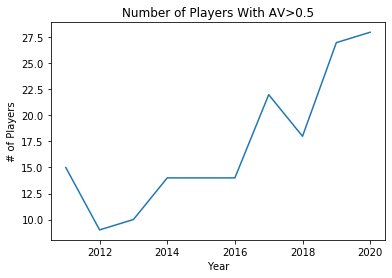

In [53]:
lst = []
for i in range(2011,2021):
    season = regular_2010[regular_2010['Year'] == i]
    season = season[season['AV'] > 0.5]
    lst.append(len(season))

plt.plot(range(2011,2021), lst)
plt.xlabel('Year')
plt.ylabel('# of Players')
plt.title('Number of Players With AV>0.5');

We see that it has nearly doubled by the end of the decade.  This suggests that defining a star player as those having an AV greater than 0.5 is not an appropriate way to evaluate whether the distribution of star players has changed because we have more players that meet the criteria which consequently drives the number of teams with more than one star player upwards.  Furthermore, we actually see an increase in AV across the league as a whole with the most pronounced increase being amongst players that are in the top 5%.

In [54]:
#The next four cells create the line graph that follows
lst1 = []
lst2 = []
lst3 = []
lst4 = []
for i in range(2011,2021):
    season = regular_2010[regular_2010['Year'] == i]
    season = season.sort_values('AV', ascending=False)
    num1 = round((len(season)*(0.05)))
    num2 = round((len(season)*(0.2)))
    num3 = round((len(season)*(0.5)))
    num4 = round((len(season)*(1)))
    season1 = season[:num1]
    season2 = season[:num2]
    season3 = season[:num3]
    season4 = season[:num4]
    lst1.append(season1['AV'].mean())
    lst2.append(season2['AV'].mean())
    lst3.append(season3['AV'].mean())
    lst4.append(season4['AV'].mean())
lst = lst1,lst2,lst3,lst4

In [55]:
df = pd.DataFrame(data = lst).T
df.columns = ['top5%','top20%','top50%','Whole League']
df['Year'] = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
df.set_index('Year', inplace = True)
data =df.reset_index().melt('Year')

In [56]:
base = alt.Chart(data).mark_line().encode(
    x = alt.X('Year',title = None, axis=alt.Axis(labelAngle=0)),
                                       
    y = alt.Y('value', scale = alt.Scale(domain =[0.2,0.6]), title = 'Approximate Value'),
    color = alt.Color('variable', legend = None)
).properties(width = 300, height = 400, title = 'AV by Various Segments of Players')

annotations = [['2013', 0.53, 'Top 5%'],
              ['2013', 0.45, 'Top 20%'],
              ['2013', 0.35, 'Top 50%'],
              ['2013', 0.26, 'Whole League']]
c_df = pd.DataFrame(annotations, columns=['AV','salary','note'])
annotation = alt.Chart(c_df).mark_text(align = 'center', baseline = 'middle', dx=7, lineBreak = '\n',
                                       style ='bond', fontSize=20).encode(
    x='AV', y='salary', text='note')

In [57]:
#This cell creates the bar chart that follows
bar_lst = []
for i in df.columns:
    a = round((df['{}'.format(i)].max() - df['{}'.format(i)].min())/df['{}'.format(i)].min(),3)*100
    bar_lst.append(a)
df_bar = pd.DataFrame(data = bar_lst, columns = ['AV'])
df_bar['Categories'] = df.columns

In [58]:
((base + annotation) | (bar + text)).configure_axis(
    grid=False
).configure_view(
    strokeOpacity=0
).properties(title = {'text':['Player Improvement'],
                      'subtitle':["Top tier players see more improvement than the rest",''],
                      'subtitleFontSize': 16,'fontSize': 20,'anchor':'start'})

alt.HConcatChart(...)

We can now provide a more definitive answer to our question by concluding that the distribution of star players has not become more concentrated – rather, it has remained relatively the same.  What we are seeing is an overall increase in the quality of players throughout the league, particularly amongst the top tier players.  Ultimately, this trend may give the appearance that the distribution of star players is more concentrated but there is simply not enough evidence here to directly support any such claim.

### Statement of Work
Matthew was responsible for collecting the per-game statistics through the utilization of HTML web scraping from Basketball Reference.  His role entailed a greater emphasis on writing and elaboration.  Li was responsible for gathering the data from sportsdata.io.  His role entailed a greater emphasis on coding and creating visualizations.  There was, however, considerable overlap between roles as we were both responsible for, to some extent, the necessary exploration, visualization, and analysis.


### References
Basketball Statistics and History. Retrieved February, 2021, from https://www.basketball-reference.com/<br /><br />
NBA Database: NBA API: Sports Data API. Retrieved February, 2021, from https://sportsdata.io/nba-api<br /><br />
Approximate Value (AV) Explained. (2020, June 19). Retrieved from https://www.nbastuffer.com/analytics101/approximate-value/<br /><br />
Trade Value Explained. (2020, June 23). Retrieved from https://www.nbastuffer.com/analytics101/trade-value/
